In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu
import math
import cutax

Start import
Working on midway2-0411.rcc.local with the following versions 
and installation paths:
strax
	v1.1.0	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen
	v1.1.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen



In [2]:
st = cutax.xenonnt_v5(cuts_for=['commissioning.krypton_selections', 'commissioning.commissioning_cuts'])

In [17]:
dsets = st.select_runs(include_tags='*sr0*', run_mode='*kr*',available='event_info')

In [18]:
dsets

,name,number,mode,end,source,start,tags,livetime,event_info_available,raw_records_available,peak_basics_available


In [7]:
dsets1 = dsets[(dsets.end > pd.to_datetime('08/09/2021'))&(dsets.end < pd.to_datetime('08/26/2021'))]

In [8]:
Kr_runs = np.array(dsets1['name'])

In [9]:
Kr_runs

array([], dtype=object)

In [68]:
ev = merge_runs_kr(st,Kr_runs)

Reading runs from 026399 to 026482
n. 4 run 026467 elapsed time: 19.25 s
n. 9 run 026452 elapsed time: 46.39 s
n. 14 run 026437 elapsed time: 76.08 s
n. 19 run 026422 elapsed time: 118.22 s
n. 24 run 026407 elapsed time: 171.59 s


In [6]:
#ev.to_pickle('data/SR0_v4_Kr83m_20210825_double.pkl')
#ev.to_pickle('data/SR0_v4_Kr83m_20210810_11_double.pkl')
#ev = pd.read_pickle('data/SR0_v4_Kr83m_20210810_11_double.pkl')
ev = pd.read_pickle('data/SR0_v4_Kr83m_20210825_double.pkl')

In [25]:
def diffusion_analysis_kr(ev, title = 'Kr83m', fit_range = (100,1500), FV = True, plot = False ):
    #if(plot): ddu.plot_area_width_aft_kr(ev, title)
    mask = ddu.mask_KrSingleS1(ev)
    mask &= (ev['cut_s1_max_pmt'])
    mask &= (ev['cut_daq_veto']) & (ev['cut_s1_area_fraction_top']) & (ev['cut_s2_single_scatter'])
    maskNW, maskFW = wcu.mask_events_near_wire(ev)
    maskFV = ev['cut_fiducial_volume']
    if(plot): ddu.plot_area_width_aft_kr(ev[mask&maskFW], title)
    #wcu.plot_r2_z(ev[mask],title)
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity_kr(ev[mask&maskFW], title, plot=plot)
    if FV: evD = ev[mask & maskFW & maskFV]
    else: evD = ev[mask & maskFW]
    d, d_err, par, par_err = ddu.diffusion_constant_kr(evD,title,fit_range=fit_range,vd = vd,plot=plot)
    #return run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift, par, par_err

total events 537703
Drift velocity = 0.708~mm/$\mu$s


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Diffusion constant = 48.69 +/- inf cm$^2$/s 


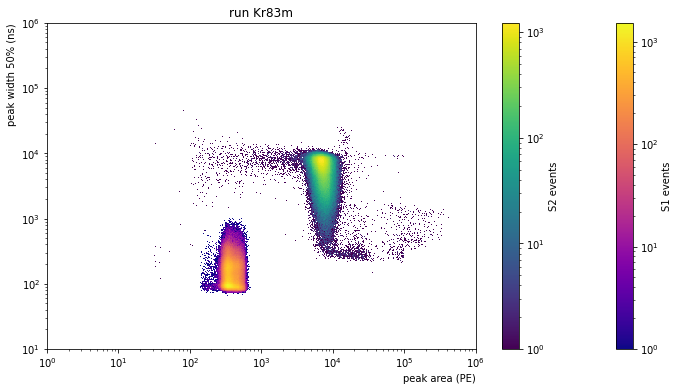

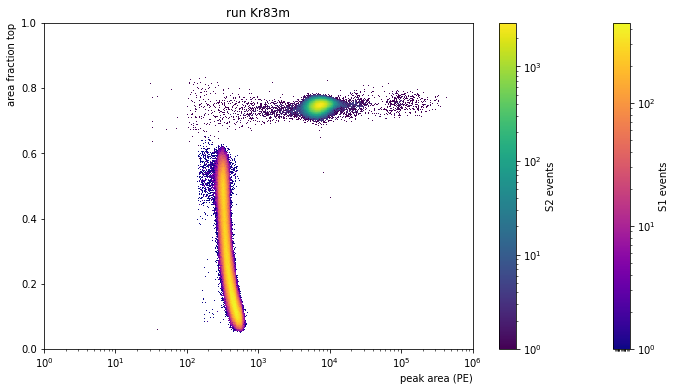

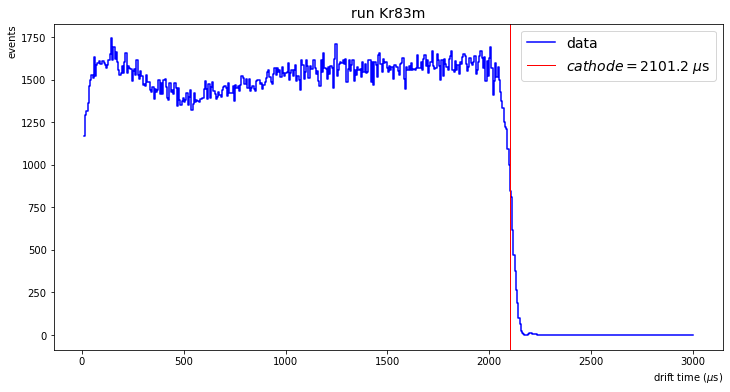

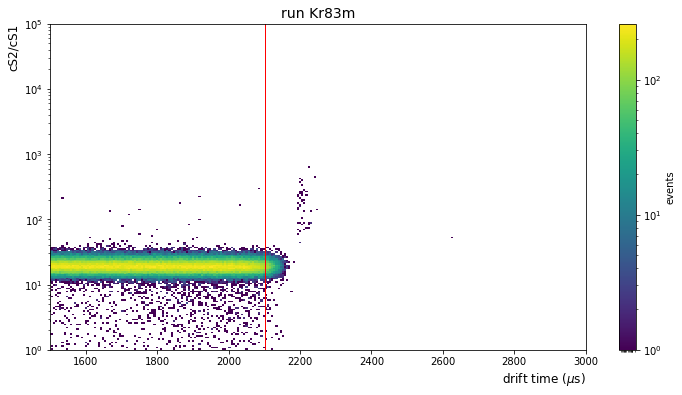

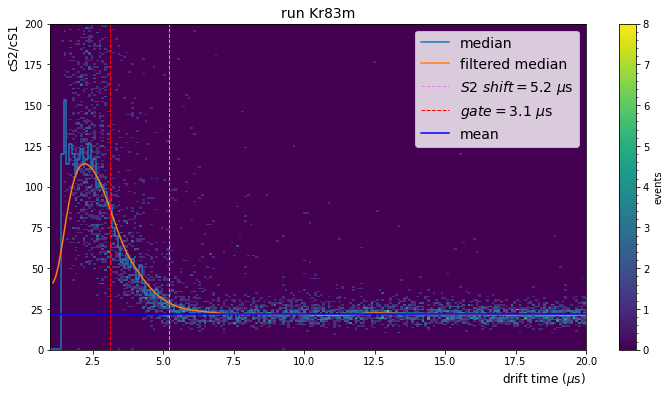

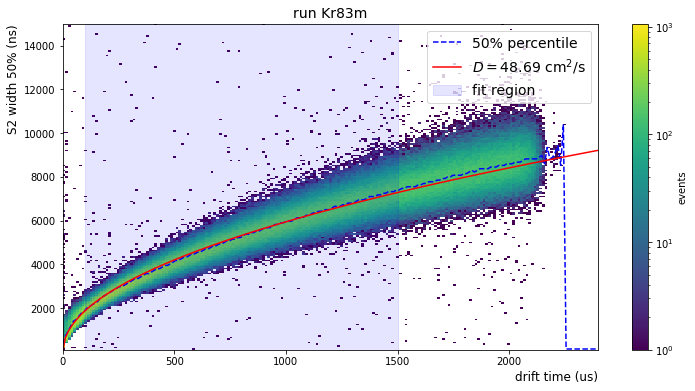

In [27]:
diffusion_analysis_kr(ev,FV=0,plot=1)

In [ ]:
def compare_drift_velocity(vd_SR0,vd_SR0_err,ms=5):
    with open("DriftVelocity.txt") as f:
        data = f.read()
    data = data.split('\n')
    ind = [row.split('\t')[0] for row in data]
    dt = [row.split('\t')[1] for row in data]
    dv = [row.split('\t')[2] for row in data]
    dt, dv = np.array(dt, dtype=np.float32), np.array(dv, dtype=np.float32)

    with open("DriftVelocity-Hogenbirk.txt") as f:
        data = f.read()
    data = data.split('\n')
    ff = [row.split(' ')[0] for row in data]
    dd = [row.split(' ')[1] for row in data]
    fe = [row.split(' ')[2] for row in data]
    de = [row.split(' ')[3] for row in data]
    ff, fe = np.array(ff, dtype=np.float32), np.array(fe, dtype=np.float32)
    dd, de = np.array(dd, dtype=np.float32), np.array(de, dtype=np.float32)

    with open("DriftVelocity-Njoya.txt") as f:
        data = f.read()
    data = data.split('\n')
    f_n = [row.split(' ')[0] for row in data]
    d_n = [row.split(' ')[1] for row in data]
    d_n, f_n = np.array(d_n, dtype=np.float32), np.array(f_n, dtype=np.float32)

    with open("DriftVelocity-Gushchin.txt") as f:
        data = f.read()
    data = data.split('\n')
    f_g = [row.split(' ')[0] for row in data]
    d_g = [row.split(' ')[1] for row in data]
    d_g, f_g = np.array(d_g, dtype=np.float32), np.array(f_g, dtype=np.float32)
    
    #vd_nT, vd_nT_err = [0.63,0.631], [0.006,0.003]
    #vd_nTb, vd_nTb_err = [0.596,0.619, 0.622], [0.005,0.003,0.003]
    #field_nT = np.full(len(vd_nT),18.3)
    #field_nTb = np.full(len(vd_nTb),18.3)
    field_1T, vd_1T = [155,134,124,92.8], [1.482,1.456,1.440,1.371]
    field_SR0 = np.full(len(vd_SR0),20.3)
    #plt.figure(figsize=(8,4.5))
    fig, ax = plt.subplots(figsize=(8,4.5))
    plt.xlabel('drift field (V/cm)',ha='right',x=1)
    plt.ylabel('drift velocity (mm/$\mu$s)',ha='right',y=1)
    #plt.xscale('log')
    plt.errorbar(dt,dv,yerr=dv*0.02, fmt='o', label='Miller (1968)')
    plt.errorbar(f_g,d_g,yerr=0, fmt='o', label='Gushchin (1982)')
    plt.errorbar(ff,dd,xerr=fe,yerr=de, fmt='o', label='Hogenbirk (2018)')
    plt.errorbar(f_n,d_n,yerr=0, fmt='o', label='Njoya (2019)')
    plt.errorbar(field_1T, vd_1T, yerr=0,fmt='X',c='black',ms=8,lw=0,label='XENON1T')
    #plt.errorbar(field_nTb,vd_nTb,yerr=vd_nTb_err,fmt='o',c='b',ms=10,lw=0,label='XENONnT - bkg')
    #plt.errorbar(field_nT, vd_nT, yerr=vd_nT_err,fmt='o',c='r',ms=10,lw=0,label='XENONnT - Kr83m')
    plt.errorbar(field_SR0, vd_SR0, yerr=vd_SR0_err,fmt='X',c='b',ms=8,lw=0,label='XENONnT - SR0')
    plt.xlim(0,220)
    plt.ylim(0.15,1.75)
    plt.legend()
    axin = ax.inset_axes([0.34, 0.1, 0.3, 0.38])
    axin.errorbar(dt,dv,yerr=dv*0.02, fmt='o', label='Miller (1968)')
    axin.errorbar(f_g,d_g,yerr=0, fmt='o', label='Gushchin (1982)')
    axin.errorbar(ff,dd,xerr=fe,yerr=de, fmt='o', label='Hogenbirk (2018)')
    axin.errorbar(f_n,d_n,yerr=0, fmt='o', label='Njoya (2019)')
    #axin.errorbar(field_nTb,vd_nTb,yerr=vd_nTb_err,fmt='o',c='b',ms=10,lw=0,label='XENONnT - bkg')
    #axin.errorbar(field_nT, vd_nT, yerr=vd_nT_err,fmt='o',c='r',ms=10,lw=0,label='XENONnT - Kr83m')
    axin.errorbar(field_SR0, vd_SR0, yerr=vd_SR0_err,fmt='X',c='b',ms=8,lw=0,label='XENONnT - SR0')
    axin.set_xlim(16.3,24.3)
    axin.set_ylim(0.5,0.7)
    #axin.set_xticklabels('')
    #axin.set_yticklabels('')
    ax.indicate_inset_zoom(axin)
    plt.savefig('driftvelocity-comparison.png',dpi=600)

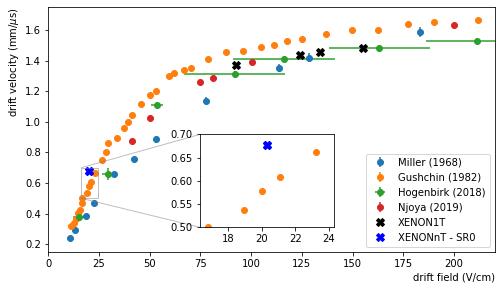

In [ ]:
compare_drift_velocity((vd1,vd1),(vd_err1,vd_err1))

In [10]:
def compare_diffusion(d_SR0,d_SR0_err,ms=5):
    diff_nT = [43.0, 42.7]
    diff_nT_err = [0.06, 0.02]
    diff_nTb = [45.3, 49.3, 52.1]
    diff_nTb_err = [0.6, 0.3, 0.3]
    field_nT = np.full(len(diff_nT),18.3)
    field_nTb = np.full(len(diff_nTb),18.3)
    field_SR0 = np.full(len(d_SR0),20.3)
    plt.figure(figsize=(12,6))
    #plt.errorbar(field_nTb,diff_nTb,yerr=diff_nTb_err,fmt='o',ms=ms,color='b',label='bkg - commissioning')
    plt.errorbar(field_nT,diff_nT,yerr=diff_nT_err,fmt='o',ms=ms,color='r',label='Kr83m - commissioning')
    plt.errorbar(field_SR0,d_SR0,yerr=d_SR0_err,fmt='o',ms=ms,color='g',label='Kr83m - SR0')
    plt.xlabel("drift field (V/cm)", ha='right', x=1)
    plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1)
    plt.legend()

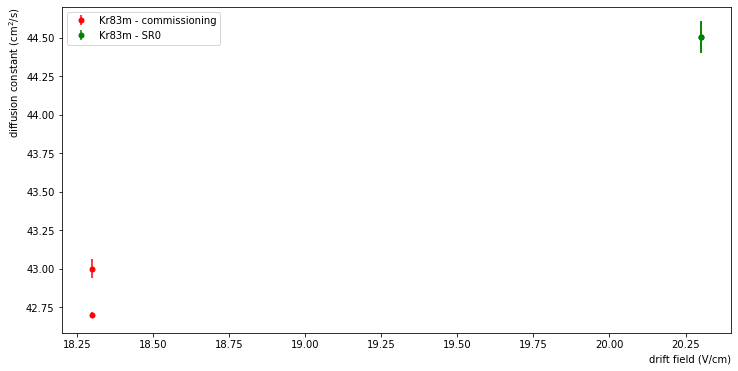

In [11]:
compare_diffusion((diff1,diff1), (diff_err1,diff_err1))

(6.2e-05, 6.9e-05)

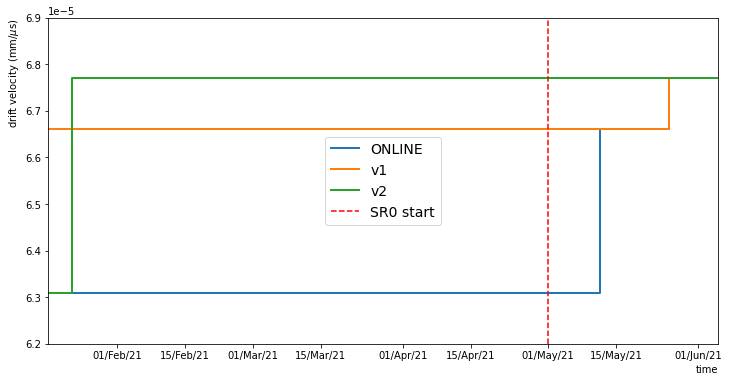

In [68]:
import matplotlib.dates as mdates
times = ['2017-01-01 00:00:00+00:00','2021-01-22 19:04:58+00:00','2021-05-01 00:00:00+00:00',
         '2021-05-11 17:55:00+00:00','2021-05-25 21:20:00+00:00','2021-06-05 00:00:00+00:00',
         '2030-12-31 23:59:59+00:00']
time = pd.to_datetime(times)
v_online = [0.00013325, 6.31e-05, 6.31e-05, 6.31e-05, 6.66e-05, 6.77e-05, 6.77e-05]
v1 = [0.00013325, 6.66e-05, 6.66e-05, 6.66e-05, 6.66e-05, 6.77e-05, 6.77e-05]
v2 = [0.00013325, 6.31e-05, 6.77e-05, 6.77e-05, 6.77e-05, 6.77e-05, 6.77e-05]
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b/%y'))
plt.plot(time,v_online,lw=2,label='ONLINE',ds='steps')
plt.plot(time,v1,lw=2,label='v1',ds='steps')
plt.plot(time,v2,lw=2,label='v2',ds='steps')
#plt.axvline(time[1],c='black',ls='--',label='commissioning start')
plt.axvline(time[2],c='r',ls='--',label='SR0 start')
plt.xlabel('time',ha='right',x=1)
plt.ylabel('drift velocity (mm/$\mu$s)',ha='right',y=1)
plt.legend(fontsize=14)
plt.xlim(time[1] - np.timedelta64(5, 'D'),time[5])
plt.ylim(6.2e-5,6.9e-5)